## Setups

In [ ]:
%reload_ext autoreload
%autoreload 2

import os
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
os.environ['KERAS_BACKEND'] = 'torch'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # force CPU usage
import mne
from scipy.signal import welch

import torch
import keras
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import json
from src.EEGModalNet.data.dataloader import LEMONEEGDataModule
from src.EEGModalNet.models.gan import SimpleGAN
from src.EEGModalNet.data.mock_temporal_data import MockTemporalData
from src.EEGModalNet.utils import ProgressBarCallback
from src.EEGModalNet.models.WGAN import WGAN_GP
from tqdm.auto import tqdm


# helper functions
def train_model(model, x, max_epochs, early_stopping=True, logger_dir='tmp/keras_logs/simple_gan_v1.csv', patience=100):
    reusable_pbar=tqdm(total=max_epochs, unit='epoch', leave=False, dynamic_ncols=True)
    
    model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
                d_optimizer=keras.optimizers.Adam(0.001),
                g_optimizer=keras.optimizers.Adam(0.0001))
    
    callbacks = [keras.callbacks.CSVLogger(logger_dir),
                 ProgressBarCallback(n_epochs=max_epochs, n_runs=1, run_index=0, reusable_pbar=reusable_pbar)]
    if early_stopping:
        callbacks.append(keras.callbacks.EarlyStopping(monitor='d_loss', mode='min', patience=patience))

    history = model.fit(
        x,
        epochs=max_epochs,
        verbose=0, # type: ignore
        shuffle=True,
        callbacks=callbacks
    )
    return history

def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['d_loss'], label='discriminator')
    plt.plot(history.history['g_loss'], label='generator')
    plt.legend()
    plt.show()

def plot_step_losses(step_loss_history):
    plt.figure(figsize=(10, 5))
    plt.plot(step_loss_history.step_losses['d_loss'], label='discriminator')
    plt.plot(step_loss_history.step_losses['g_loss'], label='generator')
    plt.legend()
    plt.show()

sns.color_palette("viridis", as_cmap=True)
sns.set_style('darkgrid')

# Plotting helper functions
def plot_onebyone(x_gen, x, n_seg=5, ch=0, time_dim=512, start_from=0, figsize=(10, 5)):
    for i in range(start_from, n_seg+start_from):
        plt.figure(figsize=figsize)
        plt.plot(x_gen[i, :time_dim, ch], label='generated')
        plt.plot(x[i, :time_dim, ch], label='real')
        plt.xlim(0, time_dim)
        plt.legend()
        plt.show()

def plot_overlap(x, n_seg=5, ch=0, time_dim=512, start_from=0, show=True):
    plt.figure(figsize=(20, 2))
    for i in range(start_from, start_from+n_seg):
        plt.plot(x[i, :time_dim, ch])
    plt.xlim(0, time_dim)
    if show:
        plt.show()

def plot_psd(x, fmin=1, ch=0, fmax=60, n_fft=512, label='real', show=True):
    psd, freq = mne.time_frequency.psd_array_welch(x[:, :, [ch]].flatten(0, 1).permute(1, 0).numpy(), sfreq=128, fmin=fmin, fmax=fmax, n_fft=n_fft)
    plt.plot(freq, 10*np.log10(psd.mean(0)), label=label)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB/Hz)')
    if show:
        plt.legend()
        plt.show()

def compare_psds(x, x_gen, lim=[20, 100], nperseg=2048, nfft=2048):
    f, Pxx = welch(x, fs=128, nperseg=nperseg, nfft=nfft)
    f_gen, Pxx_gen = welch(x_gen, fs=128, nperseg=nperseg, nfft=nfft)
    plt.plot(f[lim[0]:lim[1]], Pxx[lim[0]:lim[1]], label='real')
    plt.plot(f_gen[lim[0]:lim[1]], Pxx_gen[lim[0]:lim[1]], label='generated')
    plt.legend()
    plt.show()

def find_channel_ids(dataarray, ch_names):
    return [i for i, ch in enumerate(dataarray.channel.to_numpy()) if ch in ch_names]

def plot_2d_components(x, x_gen, ch=0, method='tsne'):
    x, x_gen = x[:, :, [ch]], x_gen[:, :, [ch]]
    sample_len = x.shape[0]
    x_flat = x.mean(axis=2)
    x_flat_hat = x_gen.mean(axis=2)
      
    x_flat_final = np.concatenate((x_flat, x_flat_hat), axis = 0)
    if method == 'tsne':
        tsne = TSNE(n_components=2, verbose=1, perplexity=20, method='barnes_hut', n_jobs=-1)
    if method == 'pca':
        tsne = PCA(n_components=2)
    tsne_results = tsne.fit_transform(x_flat_final)
        
    # Plotting
    f, ax = plt.subplots(1)
    colors = ["red" for i in range(sample_len)] + ["blue" for i in range(sample_len)]
        
    plt.scatter(tsne_results[:sample_len, 0], tsne_results[:sample_len,1], 
                c = colors[:sample_len], alpha = 0.2, label = "Original")
    plt.scatter(tsne_results[sample_len:, 0], tsne_results[sample_len:, 1], 
                c = colors[sample_len:], alpha = 0.2, label = "Synthetic")

    ax.legend()
    plt.title('t-SNE plot')
    plt.xlabel('x-tsne')
    plt.ylabel('y_tsne')
    plt.show()

def plot_psd4sujects(x, channels):
    """ Plot the power spectral density for different channels for each subjects """
    psd, freq = mne.time_frequency.psd_array_welch(x, sfreq=128, n_fft=128, fmax=60)
    for j in range(x.shape[0]):
        plt.figure(figsize=(10, 5))
        for i in range(x.shape[1]):
            plt.plot(freq, 10*np.log10(psd[j, i, :]))
        # stick the channel name to the corresponding line
        for i in range(61):
            plt.text(60, 10*np.log10(psd[j, i, -1]), channels[i], fontsize=8)
        plt.title(f'Subject {j}')
        plt.show()

def plot_psd4subjects_channel(xarray, n_subjects=20, ch_list=['O1'], fmin=1, fmax=64):
    sub_ids = xarray.subject[:n_subjects].to_numpy()
    x = xarray.sel(subject=xarray.subject[:n_subjects]).to_numpy()
    ch_ids = find_channel_ids(xarray, ch_list)
    x = x[:, ch_ids, 440:]
    psd, freq = mne.time_frequency.psd_array_welch(x, sfreq=128, fmin=fmin, fmax=fmax, n_fft=512)
    psd = 10*np.log10(psd.squeeze(1))
    for i in range(psd.shape[0]):
        plt.plot(freq, psd[i])
        # stick the channel name to the corresponding line
        for i in range(len(sub_ids)):
            plt.text(60, psd[i, -1], sub_ids[i], fontsize=8)
        plt.xlabel('Frequency (Hz)')

def plot_raw4subject_channel(dataarray, sub, chann_list=['O1'], start=0, filter=True, filter_range=[1, 60]):
    if isinstance(sub, int):
        x = xarray.sel(subject=xarray.subject[sub]).to_numpy()
    else:
        x = xarray.sel(subject=sub).to_numpy()
    idx = find_channel_ids(xarray, chann_list)
    x = x[idx, :]
    if filter:
        x = mne.filter.filter_data(x, 128, filter_range[0], filter_range[1], method='fir', verbose=False)  # filter data
    x = torch.tensor(x).unsqueeze(0)
    x = x.unfold(2, 512, 512).permute(0, 2, 3, 1).flatten(0, 1)
    plot_overlap(x, start_from=start)

def save_step_losses(step_losses, filename='step_losses.json'):
    with open(filename, 'w') as f:
        json.dump(step_losses, f)

def get_data_gender_wise(xarray, gender, random_draw=False, n_subjects=20, slicer=0):
    chunk = slicer*n_subjects
    inx = 1 if gender == 'M' else 2
    ids = np.where(xarray.gender == inx)[0]
    assert chunk < len(ids), 'There is no more data to draw from'
    ids = np.random.choice(ids, n_subjects, replace=False) if random_draw else ids[chunk:n_subjects+chunk]
    return xarray.sel(subject=xarray.subject[ids]), xarray.subject[ids]

def plot_timeseries(x_gen, x, duration=512, start_from=0, figsize=(10, 5)):
    plt.figure(figsize=figsize)
    plt.plot(x_gen.squeeze().flatten()[start_from:duration], label='generated')
    plt.plot(x.squeeze().flatten()[start_from:duration], label='real')
    plt.legend()
    plt.xlim(0, duration)
    plt.show()

# Custom Callbacks
# callback to log losses at each step
class StepLossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.step_losses = {'g_loss': [], 'd_loss': []}

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        self.step_losses['g_loss'].append(logs.get('g_loss'))
        self.step_losses['d_loss'].append(logs.get('d_loss'))

/opt/homebrew/Caskroom/miniforge/base/envs/EEGModalNet/lib/python3.11/site-packages/mne/externals/tempita/__init__.py:35: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


## DATA

In [2]:
# 1. DATA
import numpy as np
from pathlib import Path
from scipy.signal import sosfilt, butter
data_path = 'data/LEMON_data/EEG_Preprocessed/'

channels = ['O1']
processed = False
filtering = True
choose_gender_wise = False
time_dim = 1024
n_subject = 202
data_chunck = 0
exclude_sub_ids=['sub-010257', 'sub-010044', 'sub-010266']

if processed:
    data_ec = {}

    # read epochs data with mne
    for i in Path(data_path).glob('sub-01000*_EC.set'):
        sub_id = i.stem
        raw_ec = mne.io.read_raw_eeglab(i, verbose=False)
        if all(item in raw_ec.ch_names for item in channels):
            raw_ec = raw_ec.pick(channels).get_data()
            data_ec[sub_id] = raw_ec
        else:
            print("Not all items in Channels exist in Raw data, will skip this subject")
            continue

    data = {k: torch.tensor(v).unfold(1, time_dim, time_dim).permute(1, 2, 0) for k, v in data_ec.items()}
    del data_ec

    # create sub_ids
    sub_ids = np.array([]).astype(int)
    for i, k in enumerate(data.keys()):
        sub_ids = np.concatenate((sub_ids, np.array([int(i)]*data[k].shape[0], dtype=int)), dtype=int)

    sub_ids = sub_ids[:, np.newaxis]

    # sanity check
    print(np.unique(sub_ids, return_counts=True))

    x = np.zeros([1, time_dim, 1])
    for k in data.keys():
        x = np.concatenate((x, data[k]), axis=0)
    x = x[1:]
    data = {'x': x, 'sub': sub_ids}

else:
    # data
    data_path = 'data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5'
    xarray = xr.open_dataarray(data_path, engine='h5netcdf')

    if choose_gender_wise:
        xm, male_ids = get_data_gender_wise(xarray, 'M', random_draw=False, n_subjects=n_subject//2, slicer=data_chunck)
        xf, female_ids = get_data_gender_wise(xarray, 'F', random_draw=False, n_subjects=n_subject//2, slicer=data_chunck)
        x = xr.concat([xm, xf], dim='subject').to_numpy()
        sub_ids = xarray.subject[:n_subject].to_numpy()
    
    else:
        sub_ids = xarray.subject[:n_subject].to_numpy()
        x = xarray.sel(subject=xarray.subject[:n_subject], channel=channels)
        if exclude_sub_ids is not None:
            x = x.sel(subject=~x.subject.isin(exclude_sub_ids))
            n_subject = len(x.subject)
        x = x.to_numpy()

    ch_list = channels
    if filtering:
        sos = butter(4, 1, btype='high', fs=128, output='sos')
        x = sosfilt(sos, x, axis=-1)
    x = torch.tensor(x).unfold(2, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
    sub = np.arange(0, n_subject).repeat(x.shape[0]//n_subject)[:, np.newaxis]
    pos = xarray.ch_positions[None].repeat(x.shape[0], 0)
    data = {'x': x, 'sub': sub, 'pos': pos}

### Data Quality Check

Effective window size : 4.000 (s)


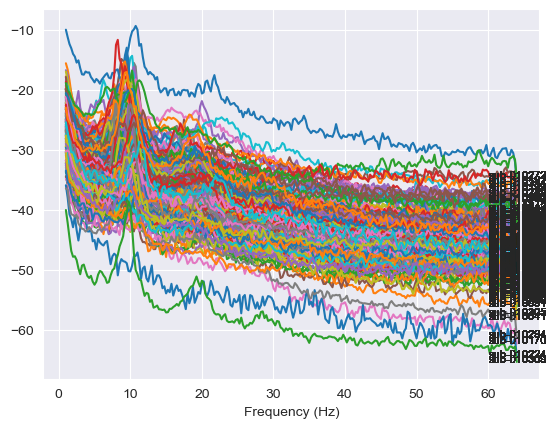

In [3]:
# make sure the PSD of the data across all the recordings is in the right shape
ch_num = 0
plot_psd4subjects_channel(xarray, n_subjects=202, ch_list=channels[ch_num], fmin=1, fmax=64)

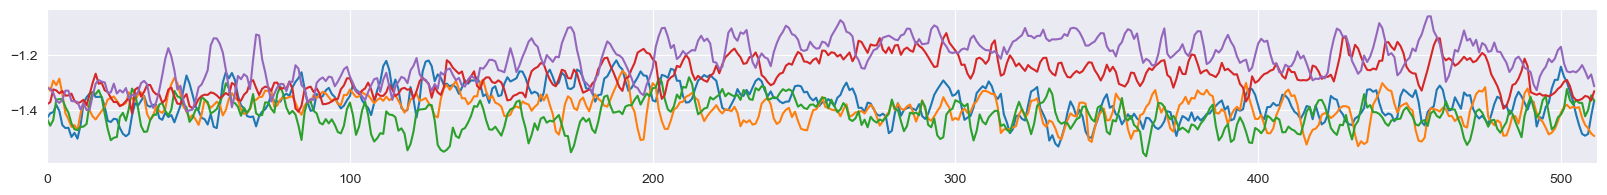

In [14]:
# inspect the data with deviant channel in time domain
sub_id = 'sub-010170'
plot_raw4subject_channel(xarray, sub=sub_id, chann_list=channels[0], start=40, filter=False, filter_range=[1, 60])

Effective window size : 4.000 (s)


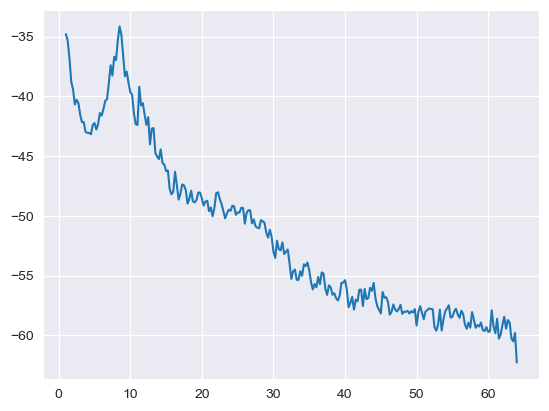

In [13]:
sub_id = 'sub-010170'
sub_224 = xarray.sel(subject=sub_id).to_numpy()
sub_224 = sub_224[find_channel_ids(xarray, channels[0]), 440:]
psd, freq = mne.time_frequency.psd_array_welch(sub_224, sfreq=128, fmin=1, fmax=64, n_fft=512)
psd = 10*np.log10(psd.squeeze(0))
plt.plot(freq, psd)

In [3]:
# check if this specific channel is excluded in LEMON preprocessed dataset
excluded_chs = pd.read_csv('data/LEMON_data/excluded_channels_ec.csv', index_col=0)

In [28]:
# make sure the channel is not excluded
excluded_chs.bad_channels.dropna().str.contains(channels[0]).sum()

0

## TRAINING

In [2]:
# 2. MODEL and Plot generated data by the model before training
load_model = False
latent_dim = 64
wgan_gp = WGAN_GP(time_dim=time_dim, feature_dim=len(channels), latent_dim=latent_dim, n_subjects=n_subject, use_sublayer_generator=True,
                  use_sublayer_critic=False, use_channel_merger=False, kerner_initializer='glorot_uniform',
                  interpolation='bilinear')
if load_model:
    wgan_gp.load_weights('logs/models/F1_5.09.2024.model.keras')

x_gen = wgan_gp.generator(keras.random.normal((len(x), latent_dim), mean=x.mean(), stddev=x.std()), torch.tensor(sub).to('mps'),
                          pos).cpu().detach()
plot_overlap(x_gen, n_seg=10, start_from=20)
plot_psd(x_gen, fmin=1, ch=0, fmax=200, n_fft=512, label='generated', show=False)
plot_psd(x, fmin=1, ch=0, fmax=200, n_fft=512, label='real', show=True)
plt.show()

NameError: name 'WGAN_GP' is not defined

In [120]:
torch.cuda.empty_cache() # clear GPU memory before training
step_losses_history = StepLossHistory()

# 3. TRAINING
wgan_gp.compile(d_optimizer=keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9),
                g_optimizer=keras.optimizers.Adam(0.001, beta_1=0.5, beta_2=0.9),
                gradient_penalty_weight=10.0)

# early stopping callback
callbacks = [keras.callbacks.EarlyStopping(monitor='g_loss', mode='min', patience=500),
             step_losses_history]

In [121]:
# training
batch_size = 64
history = wgan_gp.fit(data, epochs=20, batch_size=batch_size, callbacks=callbacks, shuffle=True)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 25s 123ms/step - critic_grad_norm: 2.9106 - d_loss: 3.2331 - g_loss: 0.0112
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - critic_grad_norm: 13.1996 - d_loss: -3.8834 - g_loss: -0.2161
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step - critic_grad_norm: 3.6809 - d_loss: -2.0003 - g_loss: -0.2964
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 23s 122ms/step - critic_grad_norm: 1.8234 - d_loss: -0.7213 - g_loss: 3.6224
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 24s 128ms/step - critic_grad_norm: 1.3096 - d_loss: -0.8520 - g_loss: 0.0218
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 24s 127ms/step - critic_grad_norm: 1.2631 - d_loss: -1.4589 - g_loss: -0.2646
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 23s 123ms/step - critic_grad_norm: 1.6860 - d_loss: -1.7734 - g_loss: 0.0162
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - critic_grad_norm: 2.1728 - d_loss: -1.8361 - g_loss: -0.0338
Epoch 9/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 24s 128ms/step - cri

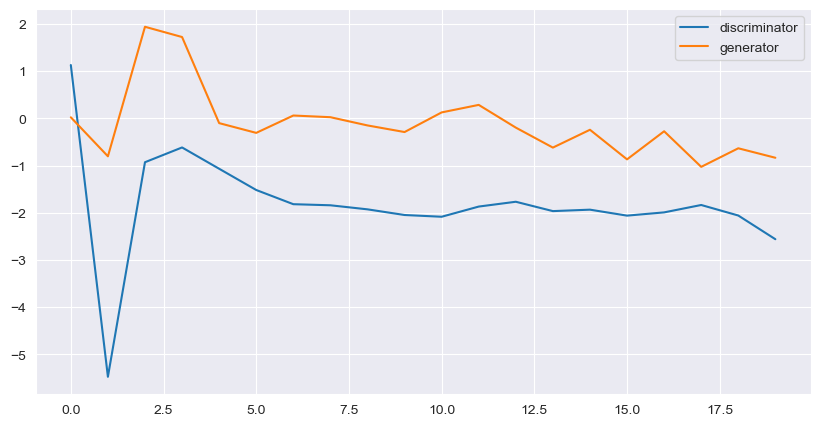

In [122]:
plot_history(history)

In [31]:
# save_step_losses(step_loss_history.step_losses, filename='data/trainings/training_29082024/step_losses/LeakyMch_step_losses_1.json')
wgan_gp.save('data/trainings/training_30082024/models/transformers.model.keras')

## Evaluations & Visualisations

In [123]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
sigmoid(wgan_gp.critic(x_gen.float().to('mps'), torch.tensor(sub).to('mps')).mean().item()), sigmoid(wgan_gp.critic(x.float().to('mps'), torch.tensor(sub).to('mps')).mean().item())

(0.9574346577166724, 0.9850465872567302)

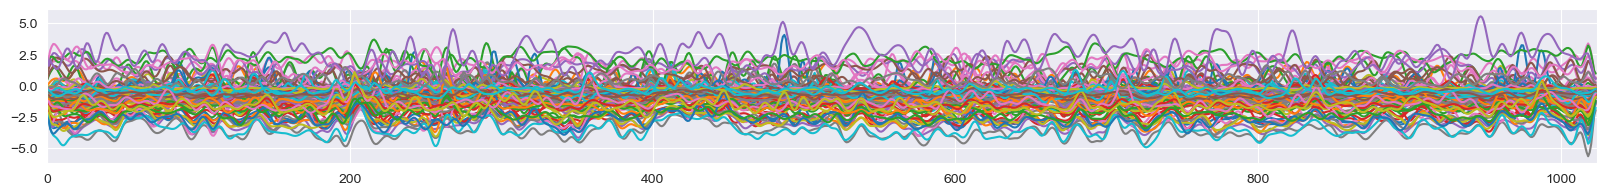

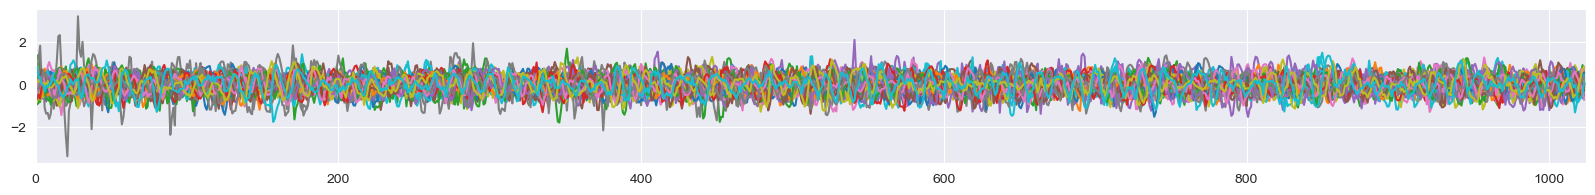

In [125]:
ch = 0
x_gen = wgan_gp.generator(keras.random.normal((len(x), latent_dim), mean=x.mean(), stddev=x.std()),
                          torch.tensor(sub).to('mps'), pos).cpu().detach()
# x_gen = wgan_gp.generator.sub_layer(x_gen.to('mps'), torch.tensor(sub).to('mps')).cpu().detach()
# filter the generated data and real data
# x_gen = mne.filter.filter_data(x_gen.numpy().astype('float'), 128, 1, 20, method='fir', verbose=False)
# x = mne.filter.filter_data(x.numpy(), 128, 1, 20, method='fir', verbose=False)
plot_overlap(x_gen, n_seg=100, ch=ch, start_from=3, time_dim=1024, show=False)
plot_overlap(x, n_seg=100, ch=ch, start_from=3, time_dim=1024, show=False)
plt.show()

### PSDs

Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


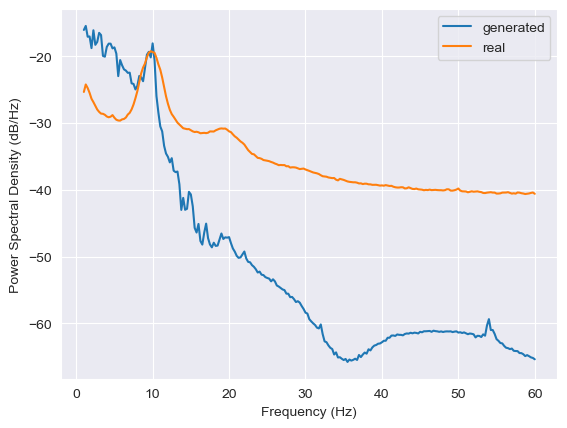

In [126]:
ch = 0
plot_psd(x_gen, fmin=1, ch=ch, fmax=60, n_fft=512, label='generated', show=False)
plot_psd(x, fmin=1, ch=ch, fmax=60, n_fft=512, label='real', show=True)
plt.show()

### tSNE

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 2360 samples in 0.003s...
[t-SNE] Computed neighbors for 2360 samples in 0.294s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2360
[t-SNE] Computed conditional probabilities for sample 2000 / 2360
[t-SNE] Computed conditional probabilities for sample 2360 / 2360
[t-SNE] Mean sigma: 0.933652
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.952934
[t-SNE] KL divergence after 1000 iterations: 2.353541


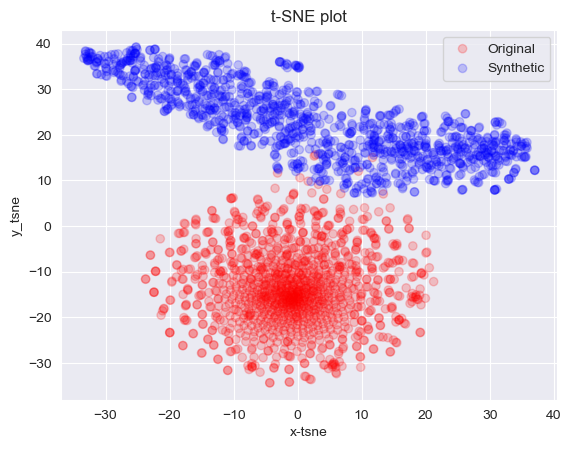

In [57]:
plot_tsne(x, x_gen, ch=0)

## Visualize each layer of Critic's and Generator's output

### Generator

In [13]:
# helper functions for plotting
def plot_neurons_act(features, across_batch=False, from_to=(20, 40), batch=0, xlim=1024):
    plt.figure(figsize=(20, 2))
    if len(features.shape) == 3:
        if across_batch:
            for i in range(from_to[0], from_to[1]):
                plt.plot(features[i, :, 0])
        else:
            for i in range(0, features.shape[2]):
                plt.plot(features[batch, :, i])

    if len(features.shape) == 2:
        for i in range(from_to[0], from_to[1]):
            plt.plot(features[i, :])
    plt.xlim(0, xlim)
    plt.show()

In [26]:
generator.model.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 256, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsample_1 (UpSampling1D)       │ (None, 512, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv1D)                 │ (None, 512, 1)         │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 512, 1)         │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_1 (LeakyReLU)        │ (None, 512, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsample_2 (UpSampling1D)       │ (None, 1024, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv1D)                 │ (None, 1024, 1)        │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 1024, 1)        │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_2 (LeakyReLU)        │ (None, 1024, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsample_3 (UpSampling1D)       │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv1D)                 │ (None, 2048, 1)        │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 2048, 1)        │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_3 (LeakyReLU)        │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsample_4 (UpSampling1D)       │ (None, 4096, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv1D)                 │ (None, 4096, 1)        │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_4 (BatchNormalization)       │ (None, 4096, 1)        │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_4 (LeakyReLU)        │ (None, 4096, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv_lyr (Conv1D)          │ (None, 4096, 4)        │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 4096, 4)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,416 (161.78 KB)

 Trainable params: 41,408 (161.75 KB)

 Non-trainable params: 8 (32.00 B)

outputs's shape: (420, 1024, 1)


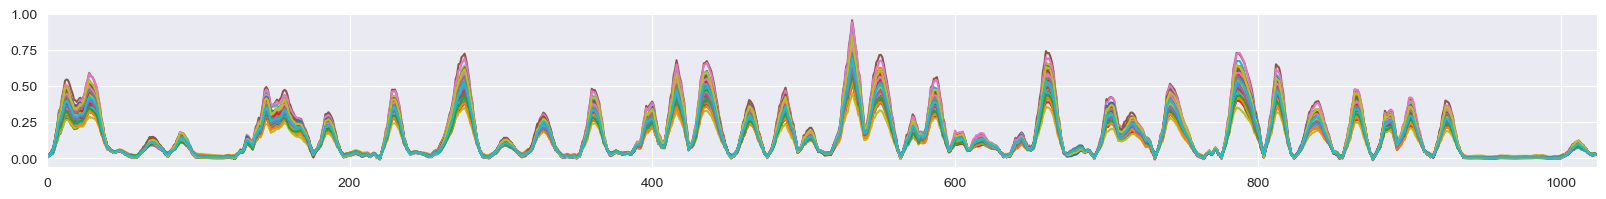

In [24]:
generator = wgan_gp.generator
out = keras.Model(generator.model.layers[0].input, generator.model.layers[10].output)
features = out(keras.random.normal((len(x), latent_dim), mean=x.mean(), stddev=x.std())).cpu().detach().numpy()
# features = generator.sub_layer(features, torch.tensor(sub).to('mps')).cpu().detach().numpy()
print(f"outputs's shape: {features.shape}")
plot_neurons_act(features, across_batch=True, from_to=(100, 200), xlim=features.shape[1])

### Critic

outputs's shape: (420, 8)


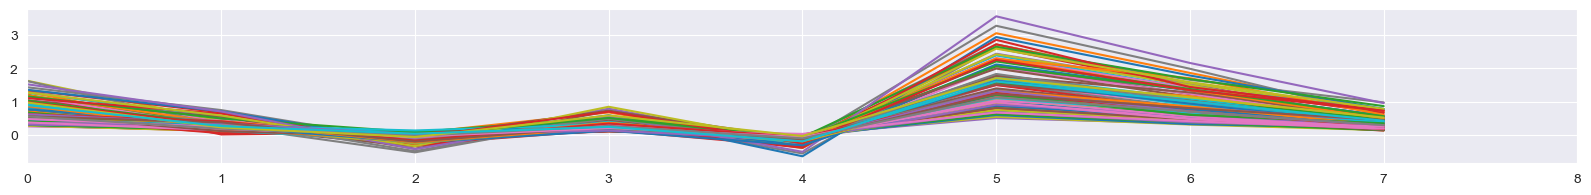

In [25]:
critic = wgan_gp.critic
model = keras.Model(inputs=critic.model.layers[0].input, outputs=critic.model.layers[-4].output)
features = model(x.float()).cpu().detach().numpy()
print(f"outputs's shape: {features.shape}")
plot_neurons_act(features, across_batch=True, from_to=(0, 100), xlim=features.shape[1])

### Position layer

(0.0, 288.0)

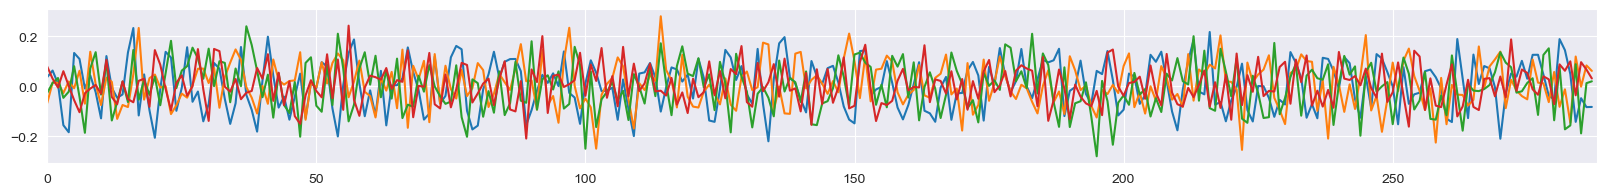

In [51]:
emb2 = wgan_gp.generator.pos_emb.get_weights()[0]
plt.figure(figsize=(20, 2))
for i in range(4):
    plt.plot(emb2[i, :])
plt.xlim(0, 288)

## Feature extraction

In [3]:
### Gender Classification
import torch
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit, cross_val_score, StratifiedShuffleSplit
from sklearn.feature_selection import VarianceThreshold

# helper functions
def open_data(path, sub=19, ch=27, seg_size=512):
    xarray = xr.open_dataarray(path, engine='h5netcdf')
    x = xarray.sel(subject=xarray.subject[sub]).to_numpy()
    x = x[ch, :]
    x = torch.tensor(x).unsqueeze(1).unfold(0, seg_size, seg_size).permute(0, 2, 1)
    return x

def take_ids(sub_ids):
    return np.array([int(i.split('-')[1][-3:]) for i in sub_ids.to_numpy()])

def find_channel_ids(dataarray, ch_names):
    return [i for i, ch in enumerate(dataarray.channel.to_numpy()) if ch in ch_names]

In [53]:
# open data and gender data
# gender classification
ch_list = ['O1', 'F1', 'O2', 'F2', 'FP1', 'FP2', 'F3', 'Cz', 'P1', 'P2', 'Pz', 'C1', 'C2', 'Fz', 'O1', 'O2']
time_dim = 512
take_rnd = 20
slicer = 0
xarray = xr.open_dataarray('data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5', engine='h5netcdf')
ch_ind = find_channel_ids(xarray, ch_list)
xf, _ = get_data_gender_wise(xarray, 'F', random_draw=False, n_subjects=take_rnd, slicer=slicer)
xm, _ = get_data_gender_wise(xarray, 'M', random_draw=False, n_subjects=take_rnd, slicer=slicer)
xf_ = torch.tensor(xf.to_numpy()[:, ch_ind, 440:]).unfold(-1, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
xm_ = torch.tensor(xm.to_numpy()[:, ch_ind, 440:]).unfold(-1, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
x_classifier = torch.cat((xf_, xm_), axis=0)

# gender labels
labels = np.array([0]*xf_.shape[0] + [1]*xm_.shape[0])

# subject ids for grouped cross validation
xf_ids, xm_ids = take_ids(xf.subject).repeat(xf_.size(0)//take_rnd), take_ids(xm.subject).repeat(xm_.size(0)//take_rnd)
sub_ids_classifier = np.concatenate((xf_ids, xm_ids))
pos = xarray.ch_positions[ch_ind]

In [6]:
cv_g = GroupShuffleSplit(n_splits=50, test_size=0.2)
cv_s = StratifiedShuffleSplit(n_splits=50, test_size=0.2)

pipe = Pipeline(steps=[
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('clf', SVC(max_iter=1000000, kernel='sigmoid', class_weight='balanced')),
])

scores_g = cross_val_score(pipe, features, labels, cv=cv_g, groups=sub_ids_classifier, n_jobs=-1)
# scores_s = cross_val_score(pipe, features, labels, cv=cv_s, n_jobs=-1)
print(f'Accuracy: {np.array(scores_g).mean() * 100:.2f}%', f'±{np.array(scores_g).std() * 100:.2f}%')

Accuracy: 53.13% ±7.09%


In [72]:
# shuffle the labels for permutation test
np.random.shuffle(labels)
scores_sh = cross_val_score(pipe, features, labels, cv=cv_g, groups=sub_ids_classifier, n_jobs=-1)

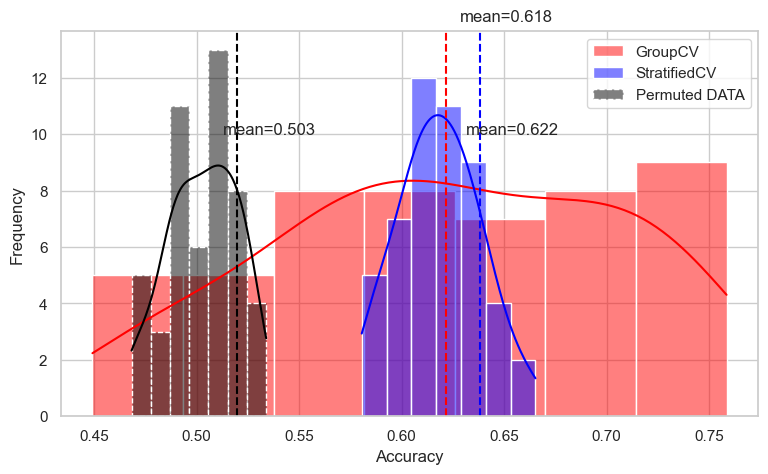

In [73]:
# visualizations
import seaborn as sns
sns.set(style='whitegrid')

plt.figure(figsize=(9, 5))
sns.histplot(scores_g, kde=True, legend=True, color='red', label='GroupCV')
sns.histplot(scores_s, kde=True, legend=True, color='blue', label='StratifiedCV')
sns.histplot(scores_sh, kde=True, legend=True, color='black', label='Permuted DATA', linestyle='--')
# Add mean and std to the plot
plt.axvline(np.array(scores_g).mean(), color='red', linestyle='--')
plt.axvline(np.array(scores_s).mean() + np.array(scores_s).std(), color='blue', linestyle='--')
plt.axvline(np.array(scores_sh).mean() + np.array(scores_sh).std(), color='black', linestyle='--')
# add text mean
plt.text(np.array(scores_g).mean() + 0.01, 10, f'mean={np.array(scores_g).mean():.3f}', fontsize=12)
plt.text(np.array(scores_s).mean() + 0.01, 14, f'mean={np.array(scores_s).mean():.3f}', fontsize=12)
plt.text(np.array(scores_sh).mean() + 0.01, 10, f'mean={np.array(scores_sh).mean():.3f}', fontsize=12)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()

### Ensemble networks

In [68]:
# 1. DATA
# open data and gender data
# gender classification
ch_list = ['O1']
time_dim = 1024
take_rnd = 40
xarray = xr.open_dataarray('data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5', engine='h5netcdf')
xf, _ = get_data_gender_wise(xarray, 'F', random_draw=False, n_subjects=take_rnd)
xm, _ = get_data_gender_wise(xarray, 'M', random_draw=False, n_subjects=take_rnd)
xf_ = torch.tensor(xf.to_numpy()[:, ch_ids, 440:]).unfold(-1, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
xm_ = torch.tensor(xm.to_numpy()[:, ch_ids, 440:]).unfold(-1, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
x = torch.cat((xf_, xm_), axis=0)

# gender labels
labels = np.array([0]*xf_.shape[0] + [1]*xm_.shape[0])

# subject ids for grouped cross validation
xf_ids, xm_ids = take_ids(xf.subject).repeat(xf_.size(0)//take_rnd), take_ids(xm.subject).repeat(xm_.size(0)//take_rnd)
sub_ids = np.concatenate((xf_ids, xm_ids))

# concate features from different networks
wgan = WGAN_GP(time_dim=1024, feature_dim=1, latent_dim=64, n_subjects=30, use_sublayer_generator=True)
wgan.load_weights('data/trainings/training_23082024/model/mostpromising_withsublayerInGenerator_chO1_sub30_epo100_trained_with_different_data.model.keras')

mode1_o1 = wgan.critic
mode1_o1 = keras.Model(inputs=mode1_o1.model.layers[0].input, outputs=mode1_o1.model.layers[-5].output)
features_o1 = mode1_o1(x.float()).cpu().detach().numpy()

In [42]:
ch_list = ['F1']
time_dim = 1024
take_rnd = 40
xarray = xr.open_dataarray('data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5', engine='h5netcdf')
xf, _ = get_data_gender_wise(xarray, 'F', random_draw=False, n_subjects=take_rnd)
xm, _ = get_data_gender_wise(xarray, 'M', random_draw=False, n_subjects=take_rnd)
xf_ = torch.tensor(xf.to_numpy()[:, ch_ind, 440:]).unfold(-1, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
xm_ = torch.tensor(xm.to_numpy()[:, ch_ind, 440:]).unfold(-1, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
x = torch.cat((xf_, xm_), axis=0)

# gender labels
labels = np.array([0]*xf_.shape[0] + [1]*xm_.shape[0])

# subject ids for grouped cross validation
xf_ids, xm_ids = take_ids(xf.subject).repeat(xf_.size(0)//take_rnd), take_ids(xm.subject).repeat(xm_.size(0)//take_rnd)
sub_ids = np.concatenate((xf_ids, xm_ids))

wgan_f1 = WGAN_GP(time_dim=1024, feature_dim=1, latent_dim=64, n_subjects=202, use_sublayer_generator=True)
wgan_f1.load_weights('logs/models/F1_5.09.2024.model.keras')
model_f1 = wgan_f1.critic
model_f1 = keras.Model(inputs=model_f1.model.layers[0].input, outputs=model_f1.model.layers[-5].output)
features_f1 = model_f1(x.float()).cpu().detach().numpy()

In [58]:
# concate features
features = np.concatenate((features_o1, features_f1), axis=1)

In [43]:
features = features_f1
cv_g = GroupShuffleSplit(n_splits=50, test_size=0.2)
cv_s = StratifiedShuffleSplit(n_splits=50, test_size=0.2)

pipe = Pipeline(steps=[
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('clf', SVC(max_iter=1000000, kernel='linear', class_weight='balanced')),
])

scores_g = cross_val_score(pipe, features, labels, cv=cv_g, groups=sub_ids, n_jobs=-1)
# scores_s = cross_val_score(pipe, features, labels, cv=cv_s, n_jobs=-1)
print(f'Accuracy: {np.array(scores_g).mean() * 100:.2f}%', f'±{np.array(scores_g).std() * 100:.2f}%')

Accuracy: 52.50% ±9.36%


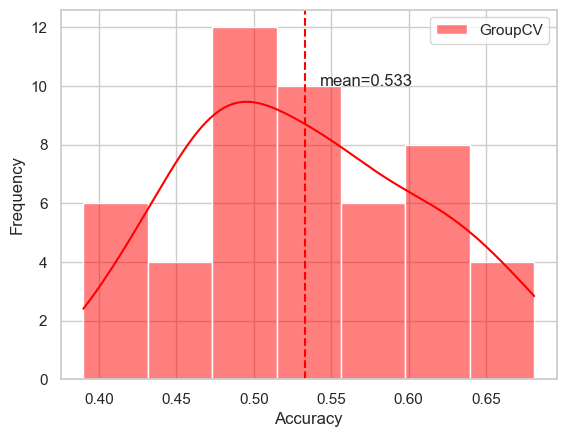

In [70]:
sns.histplot(scores_g, kde=True, legend=True, color='red', label='GroupCV')
plt.axvline(np.array(scores_g).mean(), color='red', linestyle='--')
plt.text(np.array(scores_g).mean() + 0.01, 10, f'mean={np.array(scores_g).mean():.3f}', fontsize=12)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()

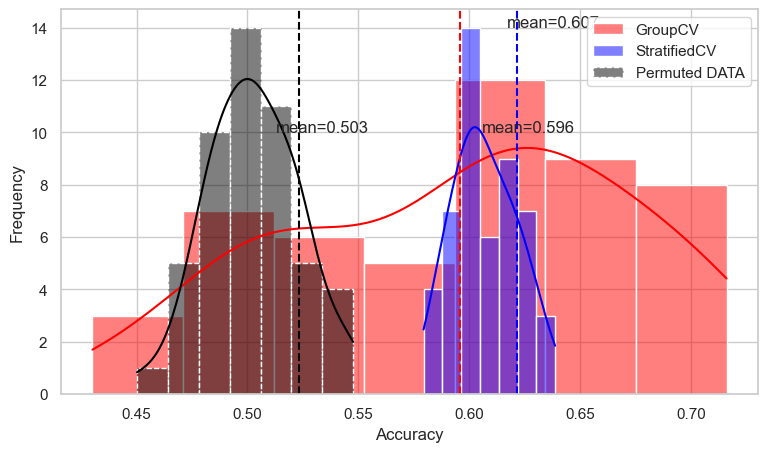

In [63]:
# visualizations
import seaborn as sns
sns.set(style='whitegrid')

plt.figure(figsize=(9, 5))
sns.histplot(scores_g, kde=True, legend=True, color='red', label='GroupCV')
sns.histplot(scores_s, kde=True, legend=True, color='blue', label='StratifiedCV')
sns.histplot(scores_sh, kde=True, legend=True, color='black', label='Permuted DATA', linestyle='--')
# Add mean and std to the plot
plt.axvline(np.array(scores_g).mean(), color='red', linestyle='--')
plt.axvline(np.array(scores_s).mean() + np.array(scores_s).std(), color='blue', linestyle='--')
plt.axvline(np.array(scores_sh).mean() + np.array(scores_sh).std(), color='black', linestyle='--')
# add text mean
plt.text(np.array(scores_g).mean() + 0.01, 10, f'mean={np.array(scores_g).mean():.3f}', fontsize=12)
plt.text(np.array(scores_s).mean() + 0.01, 14, f'mean={np.array(scores_s).mean():.3f}', fontsize=12)
plt.text(np.array(scores_sh).mean() + 0.01, 10, f'mean={np.array(scores_sh).mean():.3f}', fontsize=12)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()

In [62]:
# shuffle the labels for permutation test
np.random.shuffle(labels)
scores_sh = cross_val_score(pipe, features, labels, cv=cv_g, groups=sub_ids, n_jobs=-1)

### Notes
using the final output of the critic, results in a highest accuracy!! (could not replicate this result!)
it seems that the conv layers of the critic are responsible for getting similar outputs from different layers.


## Evaluate trained Models in HPC

In [4]:
from pathlib import Path
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def print_D_performance(x, sub):
    return sigmoid(wgan_gp.critic(x.float().to('mps'), torch.tensor(sub).to('mps')).mean().item())


mean_x = torch.tensor(6.8612e-07, dtype=torch.float64)
std_x = torch.tensor(0.2334, dtype=torch.float64)

wgan_gp = WGAN_GP(time_dim=1024, feature_dim=1,
                  latent_dim=64, n_subjects=199,
                  use_sublayer_generator=True,
                  use_sublayer_critic=False,
                  use_channel_merger=False)

In [ ]:
# Evaluate critic performance
for dir in Path('logs/outputs/O1/').glob('*.model.keras'):
    wgan_gp.load_weights(dir)
    x_gen = wgan_gp.generator(keras.random.normal((len(x), 64), mean=x.mean(), stddev=x.std()), torch.tensor(sub).to('mps'),
                              pos).cpu().detach()

    print(f'>>>>>> {dir.stem.split(".")[2][5:]}')
    print(f'real:{print_D_performance(x, sub)}')
    print(f'fake:{print_D_performance(x_gen, sub)}')

In [ ]:
# Evaluate Generator performance

# ls = ['best_gloss', 'best_dloss']
ls = range(20, 200, 20)
ls = [1260]
mean_x, std_x = x.mean(), x.std()

for i in ls:
    dir = Path(f'data/logs/archive_log_11.10.2024/O1/O1_09.10.2024_epoch_{i}.model.keras')
    wgan_gp.load_weights(dir)
    x_gen = wgan_gp.generator(keras.random.normal((len(x), 64), mean_x, std_x), torch.tensor(sub).to('mps'),
                            pos).cpu().detach()
    print(f'>>>>>> {dir.stem.split(".")[2][5:]}')
    plot_overlap(x_gen, n_seg=10, start_from=100)
    plot_onebyone(x_gen=x_gen, x=x, n_seg=1, time_dim=512, start_from=100, figsize=(20, 2))

    fig, ax = plt.subplots(figsize=(10, 4))
    plot_psd(x_gen, fmin=1, ch=0, fmax=200, n_fft=512, label='generated', show=False)
    plot_psd(x, fmin=1, ch=0, fmax=200, n_fft=512, label='real', show=False)
    ax.set_title(f'Epoch-{i}')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power Spectral Density (dB/Hz)')
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # fig.savefig(f'psds/psd_{i}.png')
    plt.show()
    plt.close(fig)

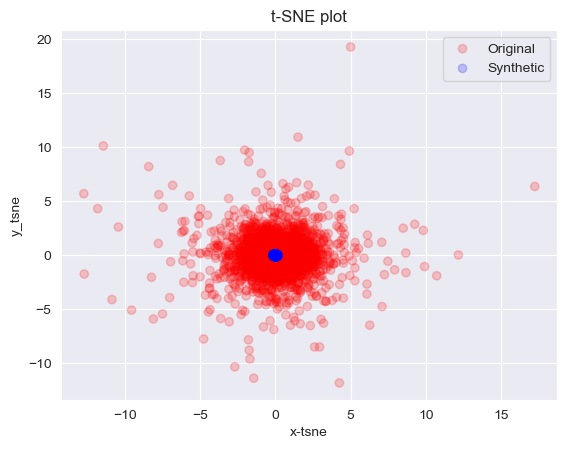

In [ ]:
for i in ls:
    dir = Path(f'data/logs/archive_log_11.10.2024/O1/O1_09.10.2024_{i}.model.keras')
    wgan_gp.load_weights(dir)
    x_gen = wgan_gp.generator(keras.random.normal((len(x), 64), mean_x, std_x), torch.tensor(sub).to('mps'),
                            pos).cpu().detach()
    plot_2d_components(x, x_gen, ch=0, method='tsne')

In [ ]:
#### create Gifs
from PIL import Image
img_list = []

for i in range(20, 1280, 20):
    img_list.append(Image.open(f'data/psds/psd_{i}.png'))

# create a git that will stop at the last frame
duration = [300] * (len(img_list)-1) + [95535]

img_list[0].save('output.gif', save_all=True, append_images=img_list[1:], duration=duration, loop=0)

In [ ]:
def plot_psd(x, fmin=1, fmax=60, n_fft=512, label='real', show=True):
    psd, freq = mne.time_frequency.psd_array_welch(x.flatten(0, 1).permute(1, 0).numpy(), sfreq=128, fmin=fmin, fmax=fmax, n_fft=n_fft)
    plt.plot(freq, 10*np.log10(psd.mean(0)), label=label)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB/Hz)')
    if show:
        plt.legend()
        plt.show()

In [ ]:
# is there any difference between data from different subjects???

(473,)

Effective window size : 8.000 (s)


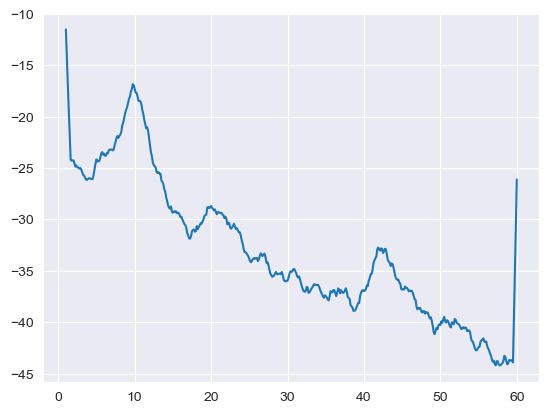

In [50]:
x_gen = wgan_gp.generator(keras.random.normal((len(x), 64), mean_x, std_x), torch.tensor(sub).to('mps'),
                            pos).cpu().detach()

psd, freq = mne.time_frequency.psd_array_welch(x_gen.flatten(0, 1).permute(1, 0).numpy(), sfreq=128, fmin=1, fmax=60, n_fft=1024,
                                               n_per_seg=1024, average=None)
                                         
def smooth(y, box_pts=10):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth                                    

plt.plot(freq, smooth(10*np.log10(psd[0, :, :10].mean(1))), label='generated')

### after psds

(0.0, 1000.0)

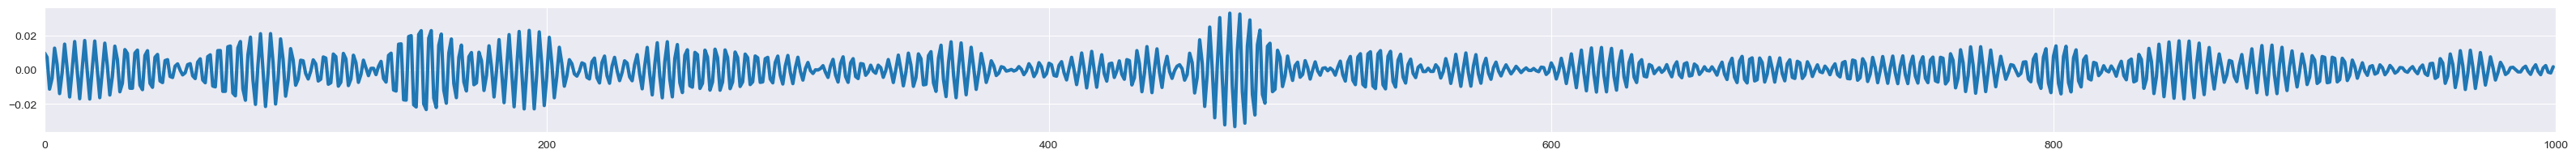

In [151]:
ch_size = 1000
chunk = 20
sos = butter(4, [30, 35], btype='band', fs=128, output='sos')
x_filtered = sosfilt(sos, x.flatten(), axis=-1)
plt.figure(figsize=(40, 2))
plt.plot(x_filtered[chunk*ch_size:(chunk+1)*ch_size], linewidth=3)
plt.xlim(0, ch_size)

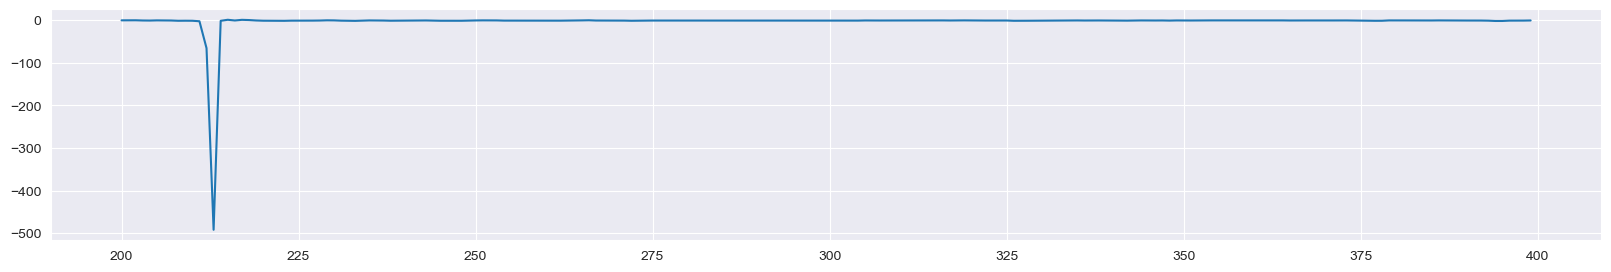

In [16]:
losses = pd.read_csv('logs/outputs/O1/11.09.2024/O1_11.09.2024_2.csv')
plt.figure(figsize=(20, 3))
plt.plot(losses.d_loss[200:400], label='discriminator')
# plt.plot(losses.g_loss, label='generator')

(0.0, 5000.0)

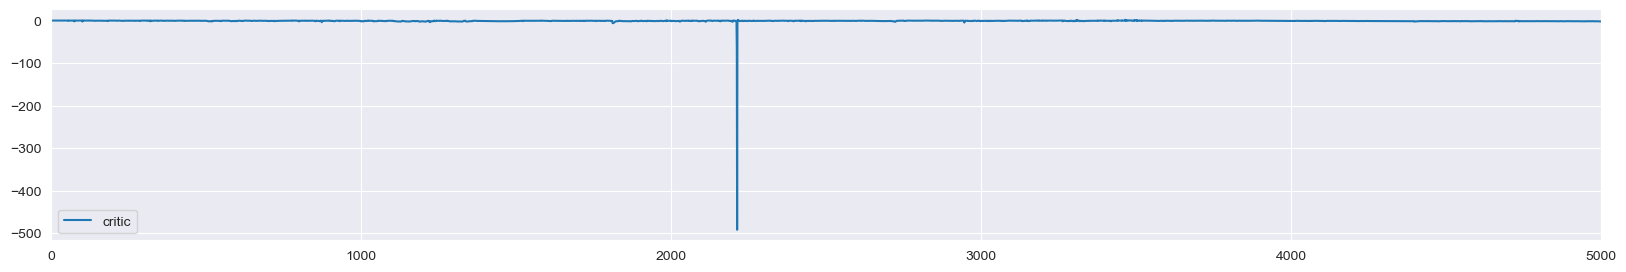

In [24]:
# plot losses
losses = pd.read_csv('logs/outputs/O1/11.09.2024/O1_11.09.2024_1.csv')
loss2 = pd.read_csv('logs/outputs/O1/11.09.2024/O1_11.09.2024_2.csv')

# combine losses
losses = pd.concat([losses, loss2], ignore_index=True)


plt.figure(figsize=(20, 3))
plt.plot(losses.d_loss, label='critic')
plt.plot(losses.g_loss, label='generator')
plt.legend()
plt.xlim(0, 5000)

In [ ]:
dirc = 'logs/outputs/O1/11.09.2024/O1_11.09.2024_epoch_3800.model.keras'
wgan_gp = WGAN_GP(time_dim=1024, feature_dim=1,
                latent_dim=64, n_subjects=199,
                use_sublayer_generator=True,
                use_sublayer_critic=False,
                use_channel_merger=False)
wgan_gp.load_weights(dirc)
x_gen = wgan_gp.generator(keras.random.normal((len(x), 64), mean=x.mean(), stddev=x.std()), torch.tensor(sub).to('mps'),
                            pos).cpu().detach()

### plot tsne

In [8]:
def plot_tsne_results(tsne_results, sample_len, save_dir):
    _, ax = plt.subplots(1)
    colors = ["red" for i in range(sample_len)] + ["blue" for i in range(sample_len)]
        
    plt.scatter(tsne_results[:sample_len, 0], tsne_results[:sample_len,1], 
                c = colors[:sample_len], alpha = 0.2, label = "Original")
    plt.scatter(tsne_results[sample_len:, 0], tsne_results[sample_len:, 1], 
                c = colors[sample_len:], alpha = 0.2, label = "Synthetic")

    ax.legend()
    # plt.title('t-SNE plot')
    plt.xlabel('x-tsne')
    plt.ylabel('y_tsne')
    plt.savefig(save_dir)
    plt.show()

In [ ]:
# uploade tsne results
sample_len = x.shape[0]  # 11940
for i in range(20, 1300, 20):
    tsne_results = np.load(f'logs/tsne/tsne_results_Epoch_{i}.npy')
    plot_tsne_results(tsne_results, sample_len, save_dir=f'data/SCEH/tsne/tsne_{i}.png')

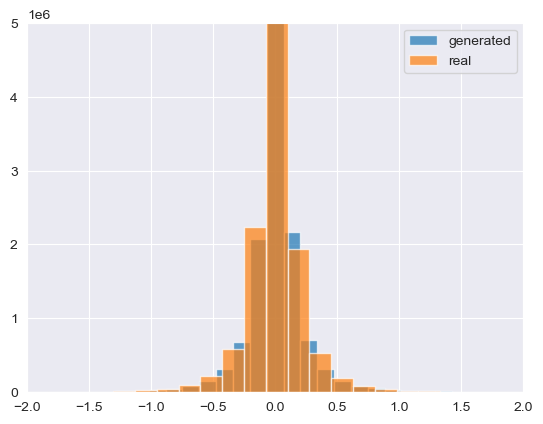

In [27]:
# plot histogram of the x_gen and x
plt.hist(x_gen.flatten(), bins=100, alpha=0.7, label='generated')
plt.hist(x.flatten(), bins=100, alpha=0.7, label='real')
plt.xlim(-2, 2)
plt.ylim(0, 5*10**6)
plt.legend()
plt.show()

## DEBUG

In [4]:
model = keras.Sequential([layers.Input(shape=(64,)),
                          layers.Dense(125, activation='relu'),
                          layers.Dense(256, activation='relu'),
                          layers.Dense(1, activation='sigmoid')])

out = model(x.float())

/opt/homebrew/Caskroom/miniforge/base/envs/eegnet-keras3/lib/python3.11/site-packages/keras/src/backend/torch/linalg.py:53: UserWarning: The operator 'aten::linalg_qr.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403251597/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch.linalg.qr(x, mode=mode)


### classification using transformer

In [37]:
excluded_chs = pd.read_csv('data/LEMON_data/excluded_channels_ec.csv', index_col=0).dropna()
ch_list = ['O1', 'F1', 'O2', 'F2', 'Fp1', 'Fp2', 'F3', 'Cz', 'P1', 'P2', 'Pz', 'C1', 'C2', 'Fz']
excluded_chs[excluded_chs['bad_channels'].apply(lambda x: any(ch in x for ch in ch_list))]

import torch.nn.functional as F
from sklearn.model_selection import train_test_split

ch_list = ['O1', 'F1', 'O2', 'F2', 'Fp1', 'Fp2', 'F3', 'Cz', 'P1', 'P2', 'Pz', 'C1', 'C2', 'Fz']
time_dim = 512
take_rnd = 20
n_subjects = 10
xarray = xr.open_dataarray('data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5', engine='h5netcdf')


xarray = xarray.sel(subject=xarray.subject[:n_subjects])
x = xarray.to_numpy()

if ch_list[0] != 'all':
    ch_ind = find_channel_ids(xarray, ch_list)
    x = x[:, ch_ind, 440:]

x = torch.tensor(x).unfold(2, time_dim, time_dim).permute(0, 2, 3, 1)

# output
y = xarray.gender[:n_subjects]
y -= 1
y = torch.tensor(y).reshape(-1, 1).repeat(1, x.shape[1])
y = F.one_hot(y, num_classes=2).float()

stratify = True
train_ids, val_ids = train_test_split(np.arange(x.shape[0]), test_size=0.2, stratify=y[:, 0].numpy() if stratify else None)
x_train, x_val = x[train_ids].flatten(0, 1), x[val_ids].flatten(0, 1)
y_train, y_val = y[train_ids].flatten(0, 1), y[val_ids].flatten(0, 1)


from keras import layers

# Custom Positional Embedding Layer
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, embed_dim):
        super(PositionalEmbedding, self).__init__()
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)
        self.sequence_length = sequence_length

    def call(self, inputs):
        positions = torch.arange(start=0, end=self.sequence_length, step=1)
        position_embeddings = self.position_embeddings(positions)
        return inputs + position_embeddings

# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-Head Self-Attention
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    
    # Residual Connection + Layer Normalization
    x = layers.Add()([x, inputs])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Feed-Forward Network
    x_ff = layers.Dense(ff_dim, activation='relu')(x)
    x_ff = layers.Dense(inputs.shape[-1])(x_ff)

    # Residual Connection + Layer Normalization
    x = layers.Add()([x, x_ff])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    return x

# EEG Model for 4-Channel Data
def build_eeg_transformer(sequence_length, embed_dim, num_heads, ff_dim, num_layers, n_channels=4):
    # Input layer for EEG data (4-channel input)
    inputs = layers.Input(shape=(sequence_length, n_channels))
    
    # Linear projection from 4 channels to embed_dim
    x = layers.Dense(embed_dim)(inputs)
    
    # Positional Embedding
    x = PositionalEmbedding(sequence_length, embed_dim)(x)
    
    # Stack multiple transformer encoders
    for _ in range(num_layers):
        x = transformer_encoder(x, head_size=embed_dim, num_heads=num_heads, ff_dim=ff_dim)

    # Global average pooling before final classification or regression
    x = layers.GlobalAveragePooling1D()(x)
    
    # Output layer (assuming regression or binary classification)
    outputs = layers.Dense(2, activation='sigmoid')(x)
    
    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs)

    # model.build(True)
    
    return model

# Parameters for EEG transformer model
sequence_length = 512  # Adjust based on your data (number of time steps)
embed_dim = 64          # Embedding dimension
num_heads = 4          # Number of attention heads
ff_dim = 128           # Feed-forward layer dimension
num_layers = 2         # Number of transformer encoder layers
n_channels = len(ch_list)         # Number of data channels

# Build and compile the model
model = build_eeg_transformer(sequence_length, embed_dim, num_heads, ff_dim, num_layers, n_channels)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Model summary
# history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_val, y_val))

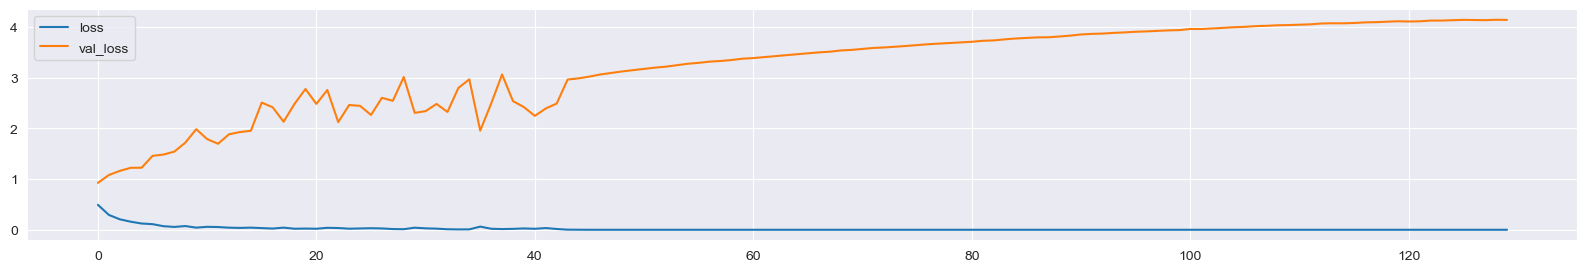

In [2]:
from sklearn.model_selection import train_test_split
ch_list = ['O1', 'F1', 'O2', 'F2', 'P1', 'P2', 'C1', 'C2']
time_dim = 512
take_rnd = 20
n_subjects = 10

losses = pd.read_csv('logs/models/classifier/transformer_16.09.2024.csv')


plt.figure(figsize=(20, 3))
plt.plot(losses.loss, label='loss')
plt.plot(losses.val_loss, label='val_loss')
plt.legend()

In [3]:
from sklearn.model_selection import train_test_split
xarray = xr.open_dataarray('data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5', engine='h5netcdf')
train_ids, test_ids = train_test_split(np.arange(20), test_size=0.2, stratify=xarray.gender[:20], random_state=42)
# train_ids, val_ids = train_test_split(train_ids, test_size=0.2, stratify=xarray.gender[train_ids], random_state=42)

In [61]:
import torch.nn.functional as F
from scipy.signal import sosfilt, butter
xarray = xr.open_dataarray('data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5', engine='h5netcdf')
x = xarray.sel(subject=xarray.subject[:20]).to_numpy()
ch_ind = find_channel_ids(xarray, ch_list)
x = x[:, ch_ind, 440:]
sos = butter(4, 1, btype='high', fs=128, output='sos')
x = sosfilt(sos, x, axis=-1)
x = torch.tensor(x).unfold(2, time_dim, time_dim).permute(0, 2, 3, 1)
y = xarray.gender[:20]
y -= 1
y = torch.tensor(y).reshape(-1, 1).repeat(1, x.shape[1])
y = F.one_hot(y, num_classes=2).float()
y_train, y_test = y[train_ids].flatten(0, 1), y[test_ids].flatten(0, 1)
x_test, x_train = x[test_ids].flatten(0, 1), x[train_ids].flatten(0, 1)

In [ ]:
from src.EEGModalNet.models.common import ResidualBlock
import keras
from keras import layers

class Critic(keras.Model):
    def __init__(self, time_dim, feature_dim, use_sublayer):
        super(Critic, self).__init__()

        self.input_shape = (time_dim, feature_dim)
        self.use_sublayer = use_sublayer

        self.model = keras.Sequential([
            keras.Input(shape=self.input_shape),
            ResidualBlock(feature_dim * 4, 5, activation='relu'),
            layers.Conv1D(1, 5, padding='same', activation='relu', name='conv3'),
            layers.Flatten(name='dis_flatten'),
            layers.Dense(512, name='dis_dense1', activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(128, name='dis_dense2', activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(32, name='dis_dense3', activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(8, name='dis_dense4', activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(2, name='sigmoid', activation='sigmoid')
        ], name='critic')
    
    def call(self, inputs):
        return self.model(inputs)

torch.cuda.empty_cache() # clear GPU memory before training
model = Critic(time_dim=512, feature_dim=8, use_sublayer=False)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_test, y_test))

### Mood prediction

In [2]:
# DATA
import torch.nn.functional as F
from scipy.signal import sosfilt, butter
from sklearn.model_selection import train_test_split

ch_list = ['O1', 'F1', 'O2', 'F2', 'P1', 'P2', 'C1', 'C2']
time_dim = 512
n_subject = 38 - 15
xarray = xr.open_dataarray('data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5', engine='h5netcdf')
x = xarray.sel(subject=xarray.subject[15:38]).to_numpy()
ch_ind = find_channel_ids(xarray, ch_list)
x = x[:, ch_ind, 440:]
sos = butter(4, 1, btype='high', fs=128, output='sos')
x = sosfilt(sos, x, axis=-1)
x = torch.tensor(x).unfold(2, time_dim, time_dim).permute(0, 2, 3, 1)

In [22]:
subscales = ['alertness']

df = pd.DataFrame()
for subscale in subscales:
    df = pd.concat([df, pd.DataFrame(xarray.attrs[subscale], columns=[subscale])], axis=1)

# Use quantile-based discretization (e.g., divide into 3 categories: low, medium, high)
for subscale in subscales:
    df[subscale + '_ordinal'] = pd.qcut(df[subscale], q=3, labels=[0, 1, 2])

# se aside a subset of data for test trainings
df = df.iloc[15:38, [1]]

df['alertness_thresh_0'] = df['alertness_ordinal'] >= 1
df['alertness_thresh_1'] = df['alertness_ordinal'] >= 2

df = df.astype({'alertness_thresh_0': 'int', 'alertness_thresh_1': 'int'})

In [7]:
# trian/val split
train_ids, test_ids = train_test_split(np.arange(x.shape[0]), test_size=0.2, stratify=df['alertness_ordinal'], random_state=42)

In [9]:
y_true = [
   torch.tensor( df['alertness_thresh_0'].values).reshape(-1, 1).repeat(1, x.shape[1]),
   torch.tensor( df['alertness_thresh_1'].values).reshape(-1, 1).repeat(1, x.shape[1])
]

In [10]:
y_train = [y[train_ids].flatten(0, 1) for y in y_true]
y_test = [y[test_ids].flatten(0, 1) for y in y_true]
x_train, x_test = x[train_ids].flatten(0, 1), x[test_ids].flatten(0, 1)

In [18]:
from src.EEGModalNet.models.common import ResidualBlock
import keras
from keras import layers

class OrdinalClassifier(keras.Model):
    def __init__(self, time_dim, feature_dim, use_sublayer):
        super(OrdinalClassifier, self).__init__()

        self.input_shape = (time_dim, feature_dim)
        self.use_sublayer = use_sublayer

        self.shared_model = keras.Sequential([
            keras.Input(shape=self.input_shape),
            ResidualBlock(feature_dim * 4, 5, activation='relu'),
            layers.Conv1D(1, 5, padding='same', activation='relu', name='conv3'),
            layers.Flatten(name='dis_flatten'),
            layers.Dense(512, name='dis_dense1', activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(128, name='dis_dense2', activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(32, name='dis_dense3', activation='relu'),
            layers.Dropout(0.3),
        ], name='shared_model')

        # Ordinal outputs: Each subscale will predict 2 thresholds (for 3 categories)
        # self.good_bad_outputs = [layers.Dense(1, activation='sigmoid', name=f'good_bad_output_{i}') for i in range(2)]
        self.awake_tired_outputs = [layers.Dense(1, activation='sigmoid', name=f'awake_tired_output_{i}') for i in range(2)]
        # self.calm_nervous_outputs = [layers.Dense(1, activation='sigmoid', name=f'calm_nervous_output_{i}') for i in range(2)]

    def call(self, inputs):
        shared_rep = self.shared_model(inputs)

        # Output predictions for each subscale (predicting thresholds)
        # good_bad_preds = [output(shared_rep) for output in self.good_bad_outputs]
        awake_tired_preds = [output(shared_rep) for output in self.awake_tired_outputs]
        # calm_nervous_preds = [output(shared_rep) for output in self.calm_nervous_outputs]

        return awake_tired_preds

In [ ]:
# Custom ordinal cross-entropy loss for cumulative probability prediction
def ordinal_loss(y_true, y_pred):
    loss = 0
    for i in range(len(y_pred)):
        # For each threshold, compare true values to predicted cumulative probabilities
        loss += keras.losses.binary_crossentropy(y_true[i], y_pred[i])
    return loss

model = OrdinalClassifier(time_dim=512, feature_dim=8, use_sublayer=False)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='ordinal_loss',
              metrics=['accuracy', 'accuracy'])

# Train the model
history = model.fit(x_test, y_test, epochs=100, batch_size=64, validation_data=(x_train, y_train))

#### Regression

In [29]:
# DATA
y = xarray.attrs['alertness'][15:38]
y = torch.tensor(y).reshape(-1, 1).repeat(1, x.shape[1])

train_ids, test_ids = train_test_split(np.arange(20), test_size=0.2)
y_train, y_test = y[train_ids].flatten(0, 1), y[test_ids].flatten(0, 1)
x_test, x_train = x[test_ids].flatten(0, 1), x[train_ids].flatten(0, 1)

In [35]:
class RegressionModel(keras.Model):
    def __init__(self, time_dim, feature_dim, use_sublayer):
        super(RegressionModel, self).__init__()

        self.input_shape = (time_dim, feature_dim)
        self.use_sublayer = use_sublayer

        self.shared_model = keras.Sequential([
            keras.Input(shape=self.input_shape),
            ResidualBlock(feature_dim * 4, 5, activation='relu'),
            layers.Conv1D(1, 5, padding='same', activation='relu', name='conv3'),
            layers.Flatten(name='dis_flatten'),
            layers.Dense(512, name='dis_dense1', activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(128, name='dis_dense2', activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(32, name='dis_dense3', activation='relu'),
            layers.Dropout(0.3),
        ], name='shared_model')

        self.awake_tired_outputs = layers.Dense(1, activation='linear', name=f'awake_tired_output')

    def call(self, inputs):
        shared_rep = self.shared_model(inputs)
        awake_tired_preds = self.awake_tired_outputs(shared_rep)

        return awake_tired_preds

In [ ]:
model = RegressionModel(time_dim=512, feature_dim=8, use_sublayer=False)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error',)

# Train the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_test, y_test))

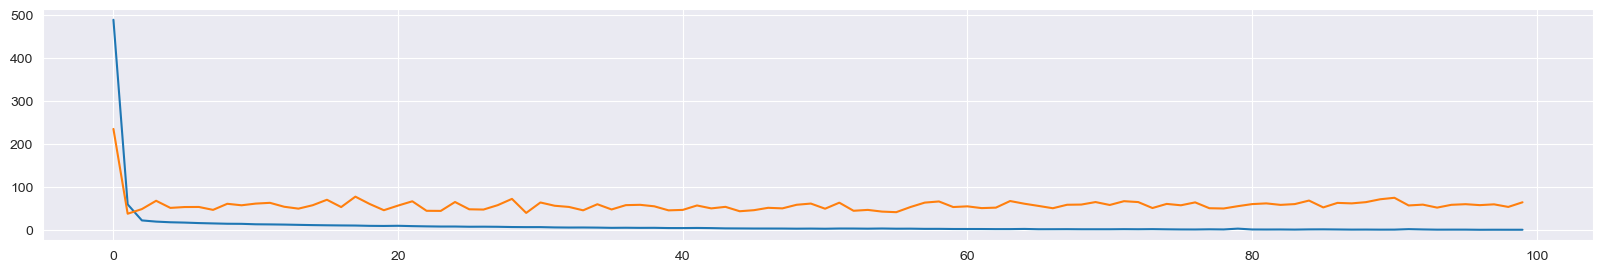

In [39]:
plt.figure(figsize=(20, 3))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

#### classification

In [45]:
# DATA
y = pd.DataFrame(xarray.attrs['alertness'][15:38], columns=['alertness'])
y['alertness_ordinal'] = pd.qcut(y['alertness'], q=2, labels=[0, 1])

y = torch.tensor(y['alertness_ordinal'].values).reshape(-1, 1).repeat(1, x.shape[1])

train_ids, test_ids = train_test_split(np.arange(23), test_size=0.2, stratify=y)
y_train, y_test = y[train_ids].flatten(0, 1), y[test_ids].flatten(0, 1)
x_test, x_train = x[test_ids].flatten(0, 1), x[train_ids].flatten(0, 1)

In [52]:
class ClassificationModel(keras.Model):
    def __init__(self, time_dim, feature_dim, use_sublayer):
        super(ClassificationModel, self).__init__()

        self.input_shape = (time_dim, feature_dim)
        self.use_sublayer = use_sublayer

        self.shared_model = keras.Sequential([
            keras.Input(shape=self.input_shape),
            ResidualBlock(feature_dim * 4, 5, activation='relu'),
            layers.Conv1D(1, 5, padding='same', activation='relu', name='conv3'),
            layers.Flatten(name='dis_flatten'),
            layers.Dense(512, name='dis_dense1', activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(128, name='dis_dense2', activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(32, name='dis_dense3', activation='relu'),
            layers.Dropout(0.3),
        ], name='shared_model')

        self.awake_tired_outputs = layers.Dense(1, activation='sigmoid', name=f'awake_tired_output')

    def call(self, inputs):
        shared_rep = self.shared_model(inputs)
        awake_tired_preds = self.awake_tired_outputs(shared_rep)

        return awake_tired_preds

In [53]:
model = ClassificationModel(time_dim=512, feature_dim=8, use_sublayer=False)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5063 - loss: 0.6776 - val_accuracy: 0.3849 - val_loss: 0.6978
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6168 - loss: 0.6252 - val_accuracy: 0.3832 - val_loss: 0.7503
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6872 - loss: 0.5312 - val_accuracy: 0.3933 - val_loss: 0.8319
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8139 - loss: 0.4268 - val_accuracy: 0.4303 - val_loss: 0.9785
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8689 - loss: 0.3190 - val_accuracy: 0.3697 - val_loss: 1.5429
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9179 - loss: 0.2132 - val_accuracy: 0.3664 - val_loss: 1.6771
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9367 - loss: 0.1691 - val_accuracy: 0.3748 - val_loss: 2.1114
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9745 - loss: 0.0959 - val_accuracy: 0.

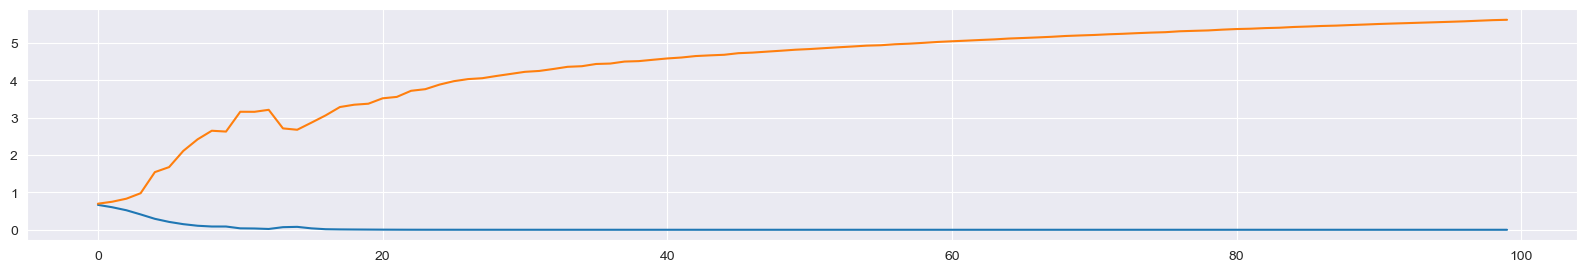

In [56]:
plt.figure(figsize=(20, 3))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')